In [1]:
import os
import sys

from pathlib import Path


# si aggiunge al path la cartella utils per avere visibilità del module
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [2]:
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.mining as mining
import utils.datasets as build

from torch import nn
from tqdm import tqdm
from skimage import io
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import miners, losses
from sklearn.model_selection import train_test_split

In [3]:
# serve per ricaricare il codice modificato
%load_ext autoreload
%autoreload 2

In [4]:
# configurazione
batch_size=32
lr=0.001
epochs=30
device="cuda"

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

# margin per semi-hard mining con modello pre-allenato
margin=0.2

In [5]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent

fake_data_dir = os.path.join(path, "artifact", "taming_transformer")
real_data_dir = os.path.join(path, "artifact", "coco")

In [6]:
# carica le immagini nel dataset
class ApnDataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if str(row.Anchor).startswith("coco"):
        a_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        p_img = io.imread(os.path.join(real_data_dir, row.Positive))
        n_img = io.imread(os.path.join(fake_data_dir, row.Negative))

        a_label = 0
        p_label = 0
        n_label = 1

      else:
        a_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        p_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        n_img = io.imread(os.path.join(real_data_dir, row.Negative))

        a_label = 1
        p_label = 1
        n_label = 0

      # normalizzazione per immagini in rgb 
      a_img = torch.from_numpy(a_img).permute(2, 0, 1) / 255.0
      p_img = torch.from_numpy(p_img).permute(2, 0, 1) / 255.0
      n_img = torch.from_numpy(n_img).permute(2, 0, 1) / 255.0

      a_label = torch.tensor(a_label)
      p_label = torch.tensor(p_label)
      n_label = torch.tensor(n_label)

    if mode == "grey_scale":
      a_img = np.expand_dims(a_img, 0)
      p_img = np.expand_dims(p_img, 0)
      n_img = np.expand_dims(n_img, 0)
      
      a_img = torch.from_numpy(a_img) / 255.0
      p_img = torch.from_numpy(p_img) / 255.0
      n_img = torch.from_numpy(n_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return a_img, p_img, n_img, a_label, p_label, n_label

In [7]:
# classe per caricare il modello di rete neurale direttamente dalle repository online
class ApnModel(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size=512):
    super(ApnModel, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b1", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [8]:
# classe del modello che genera gli embedding per applicare il semi-hard mining
class EmbModel(nn.Module):

    # size del vettore di embedding
    def __init__(self, emb_size = 512):
        super(EmbModel, self).__init__()

        # gli embedding vengono creati con un modello preallenato (risultato più efficace in test precedenti)
        self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [9]:
# funzione per creare embeddings che sarranno sottoposti a semi-hard mining
def create_embeddings(model, dataloader, device): 
    # off dropout
    model.eval()

    list_df = []

    with torch.no_grad():
        for a, p, n, al, pl, nl in tqdm(dataloader, desc="creating embeddings..."):
            a, p, n = a.to(device), p.to(device), n.to(device)

            temp_df_embs = pd.DataFrame(columns=["Anchor_embs", "Positive_embs", "Negative_embs"])

            a_embs = model(a)
            p_embs = model(p)
            n_embs = model(n)
            
            # la batch size può variare, perciò ci si basa sulla lunghezza del tensore
            batch_size = len(a_embs)
            
            # ad ogni batch corrisponde un dataframe
            for i in range(batch_size): 
                # si serializzano gli array np in stringhe in modo da memorizzarli nelle celle del datagrame
                a, p, n = a_embs[i].cpu().numpy(), p_embs[i].cpu().numpy(), n_embs[i].cpu().numpy()
                a, p, n = np.array2string(a, separator=','), np.array2string(p, separator=','), np.array2string(n, separator=',')
                
                temp_df_embs.loc[i] = [
                    a, 
                    p, 
                    n
                ]
            
            list_df.append(temp_df_embs)

    # concatenazione di tutti i dataframe
    df_embs = pd.concat(list_df)

    return df_embs

In [10]:
emb_model = EmbModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    emb_model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

emb_model.to(device)

EmbModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act):

In [11]:
path = Path(os.getcwd()).parent.parent
fake_dataset_path = os.path.join(path, "artifact", "taming_transformer", "metadata.csv")
real_dataset_path = os.path.join(path, "artifact", "coco", "metadata.csv")

# creo il dataset di triplet iniziale (i triplet sono scelti casualmente)
df_out_path = os.path.join("..", "datasets", "out.csv")
build.train(fake_dataset_path, real_dataset_path, df_out_path, 50000)

building (negative anchor) dataframe...: 100%|██████████| 25000/25000 [00:29<00:00, 840.39it/s]


In [12]:
df_out_path = os.path.join("..", "datasets", "out.csv")
df_out = pd.read_csv(df_out_path)

apn_dataset = ApnDataset(df_out)
dataloader = DataLoader(apn_dataset, batch_size=batch_size)

In [13]:
emb_csv_path = os.path.join("..", "notebooks", "embeddings.csv")

# si controlla che siano stati già creati gli embeddings
if not Path(emb_csv_path).is_file():
    df_emb = create_embeddings(emb_model, dataloader, device)
    df_emb.to_csv(emb_csv_path, index=False)

df_emb = pd.read_csv(emb_csv_path)

creating embeddings...:   0%|          | 0/1563 [00:00<?, ?it/s]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
creating embeddings...: 100%|█████████▉| 1562/1563 [1:44:05<00:02,  2.52s/it] c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
creating embeddings...: 100%|██████████| 1563/1563 [1:44:06<00:00,  4.00s/it]


In [14]:
# si concatenano i dataframe delle immagini e degli embeddings sulle colonne per poter filtrare le righe in logica di semi-hard mining
df = pd.concat([df_out, df_emb], axis=1)

# offline semi-hard mining dei triplets
df = mining.offline_semi_hard_mining(df, margin)
df = df.drop(["Anchor_embs", "Positive_embs", "Negative_embs"], axis=1)

print(f"dataset size after semi-hard mining: {len(df)}")

dataset size after semi-hard mining: 6438


In [15]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion, miner):
  # on dropout 
  model.train()
  
  total_loss = 0.0

  for a, p, n, al, pl, nl in tqdm(dataloader, desc="model training..."):
    a, p, n = a.to(device), p.to(device), n.to(device)
    al, pl, nl = al.to(device), pl.to(device), nl.to(device)

    optimizer.zero_grad()

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    a_embs = model(a)
    p_embs = model(p)
    n_embs = model(n)

    # per usare l'ohm si devono concatenare tutti i tipi di immagine, i triplet verranno creati nella funzione di loss
    embeddings = torch.cat((a_embs, p_embs, n_embs), axis=0)
    labels = torch.cat((al, pl, nl), axis=0)

    # online hard mining prima del calcolo della loss
    miner_output = miner(embeddings, labels)
    loss = criterion(embeddings, labels, miner_output)
    loss.backward()
    
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [16]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  # off dropout
  model.eval() 
  
  total_loss = 0.0

  with torch.no_grad():
    for a, p, n, al, pl, nl in tqdm(dataloader, desc="model validating..."):
      a, p, n = a.to(device), p.to(device), n.to(device)
      al, pl, nl = al.to(device), pl.to(device), nl.to(device)

      a_embs = model(a)
      p_embs = model(p)
      n_embs = model(n)

      embeddings = torch.cat((a_embs, p_embs, n_embs), axis=0)
      labels = torch.cat((al, pl, nl), axis=0)

      loss = criterion(embeddings, labels)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
model = ApnModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(device)

ApnModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
      

In [18]:
# split del nuovo dataframe
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

trainset = ApnDataset(train_df)
validset = ApnDataset(valid_df)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [19]:
# triplet loss, miner (per online hard mining) e adam
criterion = losses.TripletMarginLoss(triplets_per_anchor="all")
miner = miners.TripletMarginMiner(margin=margin, type_of_triplets="hard")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []

for i in range(epochs):
  train_loss = train_fn(model, trainloader, optimizer, criterion, miner)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model training...:  99%|█████████▉| 160/161 [05:23<00:02,  2.00s/it]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
model validating...: 100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


successful weights saving...
epochs: 1, train_loss: 0.05966048530355003, valid_loss: 0.049803529116438656


model validating...: 100%|██████████| 41/41 [00:22<00:00,  1.84it/s]


epochs: 2, train_loss: 0.05073184559341543, valid_loss: 0.04988932836709953


model validating...: 100%|██████████| 41/41 [00:22<00:00,  1.83it/s]


epochs: 3, train_loss: 0.05034899031338484, valid_loss: 0.04993710094472257


model validating...: 100%|██████████| 41/41 [01:21<00:00,  1.99s/it]


epochs: 4, train_loss: 0.050212557040016106, valid_loss: 0.04994132460617438


model validating...: 100%|██████████| 41/41 [01:04<00:00,  1.57s/it]


epochs: 5, train_loss: 0.05014991223441888, valid_loss: 0.04994306922322366


model validating...: 100%|██████████| 41/41 [00:24<00:00,  1.67it/s]


epochs: 6, train_loss: 0.05012114306692011, valid_loss: 0.04995785480955752


model validating...: 100%|██████████| 41/41 [00:24<00:00,  1.71it/s]


epochs: 7, train_loss: 0.05010718958718436, valid_loss: 0.04994635174914104


model validating...: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]


epochs: 8, train_loss: 0.05010279770130697, valid_loss: 0.049951495920739525


model validating...: 100%|██████████| 41/41 [00:25<00:00,  1.61it/s]


epochs: 9, train_loss: 0.05009762898827932, valid_loss: 0.049941293986105334


model validating...: 100%|██████████| 41/41 [00:23<00:00,  1.72it/s]


epochs: 10, train_loss: 0.05009717489621654, valid_loss: 0.04993955427553595


model validating...: 100%|██████████| 41/41 [00:32<00:00,  1.25it/s]


epochs: 11, train_loss: 0.05009457688801777, valid_loss: 0.04992915181125083


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]


epochs: 12, train_loss: 0.050092065417618487, valid_loss: 0.04994411775615157


model validating...: 100%|██████████| 41/41 [00:22<00:00,  1.85it/s]


epochs: 13, train_loss: 0.05009423494801758, valid_loss: 0.04995030564505879


model validating...: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s]


epochs: 14, train_loss: 0.0500926550778543, valid_loss: 0.049930408415271015


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.91it/s]


epochs: 15, train_loss: 0.05009557720944748, valid_loss: 0.04994172275793261


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]


epochs: 16, train_loss: 0.05009214334791492, valid_loss: 0.049938517736225596


model validating...: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s]


epochs: 17, train_loss: 0.05009355874998229, valid_loss: 0.04994737047974656


model validating...: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s]


epochs: 18, train_loss: 0.050093245362828234, valid_loss: 0.049900471164685926


model validating...: 100%|██████████| 41/41 [10:28<00:00, 15.33s/it]


epochs: 19, train_loss: 0.05009519797026741, valid_loss: 0.04994574189186096


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]


epochs: 20, train_loss: 0.05009675305915175, valid_loss: 0.04991408737330902


model validating...: 100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


epochs: 21, train_loss: 0.05009971906124435, valid_loss: 0.04993823643137769


model validating...: 100%|██████████| 41/41 [00:35<00:00,  1.17it/s]


epochs: 22, train_loss: 0.050097023385652105, valid_loss: 0.04992752422283336


model validating...: 100%|██████████| 41/41 [00:25<00:00,  1.61it/s]


epochs: 23, train_loss: 0.05009604580931782, valid_loss: 0.049911287499637136


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s]


epochs: 24, train_loss: 0.05009765490334227, valid_loss: 0.049934739110673344


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s]


epochs: 25, train_loss: 0.05009737367863241, valid_loss: 0.04990981819062698


model validating...: 100%|██████████| 41/41 [00:32<00:00,  1.25it/s]


epochs: 26, train_loss: 0.05009895148947372, valid_loss: 0.049912969695358744


model validating...: 100%|██████████| 41/41 [00:23<00:00,  1.72it/s]


epochs: 27, train_loss: 0.05009810804672863, valid_loss: 0.049914890491380925


model validating...: 100%|██████████| 41/41 [00:23<00:00,  1.77it/s]


epochs: 28, train_loss: 0.05009734012788127, valid_loss: 0.04991935711444878


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s]


epochs: 29, train_loss: 0.05010069323622662, valid_loss: 0.04992255159631008


model validating...: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s]

epochs: 30, train_loss: 0.050103490443333336, valid_loss: 0.04992341759001336


<function matplotlib.pyplot.show(close=None, block=None)>

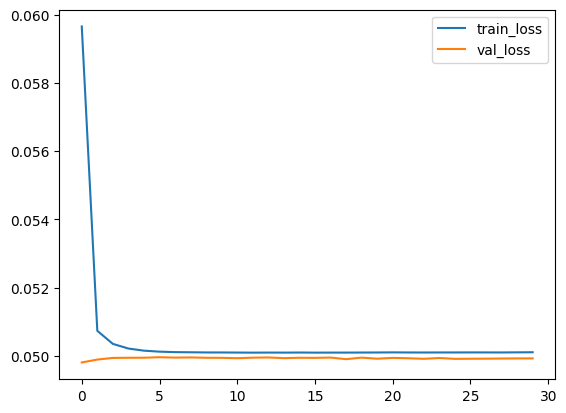

In [21]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [41]:
df = pd.read_csv(df_out_path)

path = Path(os.getcwd()).parent.parent
fake_dataset_path = os.path.join(path, "artifact", "taming_transformer", "metadata.csv")
real_dataset_path = os.path.join(path, "artifact", "coco", "metadata.csv")

# creo il dataset di test
testList_df_path = os.path.join("..", "datasets", "testList.csv")
build.test(fake_dataset_path, real_dataset_path, testList_df_path, df)

building (fake column) test dataframe...: 100%|██████████| 10000/10000 [01:20<00:00, 124.60it/s]


In [42]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr, desc="creating encodings..."):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if str(i).startswith("coco"):
          dir_folder = real_data_dir
          a = io.imread(os.path.join(dir_folder, i))

        else: 
          dir_folder = fake_data_dir
          a = io.imread(os.path.join(dir_folder, i))

        a = torch.from_numpy(a).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        a = io.imread(os.path.join(dir_folder,i))
        a = np.expand_dims(a, 0)
        a = torch.from_numpy(a.astype(np.int32)) / 255.0
        
      a = a.to(device)
      a_enc = model(a.unsqueeze(0))
      encodings.append(a_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [43]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)
df_enc.to_csv("database.csv", index=False)

creating encodings...: 100%|██████████| 50000/50000 [31:40<00:00, 26.31it/s]  


In [44]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,coco/coco2017/train2017/img043619.jpg,0.441311,1.131196,-1.847658,-0.254981,-0.831708,0.956309,-1.114014,0.640287,2.986835,...,1.079214,-3.192998,0.371518,3.109796,1.686093,1.177179,-0.211810,-0.377895,2.175065,0.971583
1,coco/coco2017/val2017/img161498.jpg,0.409707,1.058628,-1.753587,-0.210673,-0.794721,0.857949,-1.054012,0.609517,2.840643,...,1.009984,-3.045317,0.324748,2.990854,1.652221,1.156651,-0.231820,-0.364634,2.017439,0.847854
2,coco/coco2017/train2017/img079357.jpg,0.453163,1.228648,-2.043896,-0.276179,-0.979781,1.035267,-1.279278,0.761225,3.353465,...,1.182049,-3.602537,0.432285,3.512588,1.886849,1.354233,-0.251753,-0.459703,2.365719,1.000769
3,coco/coco2017/train2017/img119001.jpg,0.447512,1.112598,-1.920326,-0.268936,-0.887200,0.978291,-1.134504,0.609550,3.110232,...,1.118784,-3.341032,0.349040,3.240544,1.761347,1.252243,-0.234723,-0.398230,2.202242,0.949311
4,coco/coco2017/test2017/img019202.jpg,0.437683,1.113584,-1.890454,-0.223449,-0.900489,0.928018,-1.148402,0.678754,2.995563,...,1.058303,-3.309245,0.398535,3.105919,1.682683,1.210261,-0.174869,-0.416194,2.125974,0.945091


In [45]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [46]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0       coco/coco2017/train2017/img147222.jpg
1       coco/coco2017/train2017/img147222.jpg
2        coco/coco2017/test2017/img002282.jpg
3        coco/coco2017/test2017/img002282.jpg
4        coco/coco2017/test2017/img002282.jpg
                        ...                  
9995     coco/coco2017/test2017/img032530.jpg
9996     coco/coco2017/test2017/img032530.jpg
9997     coco/coco2017/test2017/img021234.jpg
9998     coco/coco2017/test2017/img021234.jpg
9999    coco/coco2017/train2017/img119983.jpg
Name: real, Length: 10000, dtype: object
20000


,real,fake
0,coco/coco2017/train2017/img147222.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/181/img00463...
1,coco/coco2017/train2017/img147222.jpg,tt-coco/samples_nopix/img003896.jpg
2,coco/coco2017/test2017/img002282.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img001807.jpg
3,coco/coco2017/test2017/img002282.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img027474.jpg
4,coco/coco2017/test2017/img002282.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/896/img04427...


In [47]:
def get_image_embeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [48]:
def search_in_database(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [49]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_dataset_dir = os.path.join(path, "artifact", "coco")
fake_dataset_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

temp_df = df
temp_df.head()
temp_df.shape

(10000, 2)

In [50]:
# testo i fake
current_test = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(temp_df.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_dataset_dir, row[current_test])
    img_name = path

    img = io.imread(img_name)
    img_enc = get_image_embeddings(img, model)
    closest_label = search_in_database(img_enc, database)

    if mode == "rgb":
        if str(closest_label).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale": 
        if "real" in closest_label:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 10000it [2:58:38,  1.07s/it]


In [51]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
10000
['fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real',

In [52]:
# testo i real
current_test = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(temp_df.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_dataset_dir, row[current_test])
    img_name = path

    img = io.imread(img_name)
    img_enc = get_image_embeddings(img, model)
    closest_label = search_in_database(img_enc, database)
    
    if mode == "rgb":
        if str(closest_label).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale":
        if "real" in closest_label:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 10000it [2:53:58,  1.04s/it]


In [53]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
20000
['fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real',

In [54]:
# creo i vettori di ground truth
int(len(df) / 100 * 20)

y_true = np.array(["fake"] * len(valid_df))
print(y_true.shape)

temp = np.array(["real"] * len(valid_df))
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(1288,)
(1288,)
(2576,)


ValueError: Found input variables with inconsistent numbers of samples: [2576, 20000]

In [ ]:
tn, fp, fn, tp = cm.ravel()

# metriche
accuracy = round((tp + tn) / (tp + tn + fp + fn), 4) * 100
precision = round((tp) / (tp + fp), 4) * 100
recall = round((tp) / (tp + fn), 4) * 100
specificity = round((tn) / (tn + fp) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

In [ ]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "rgb_mining", "siamese_" + mode + "_" + "pretrained_semi_hard_online_hard_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)